In [34]:

#TODO: Super upgraded walk forward optimization
#TODO: Data imputation


In [35]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import apply_clipped_optimizer
pd.set_option("display.max_columns", 200)
from sklearn.metrics import r2_score

df = pd.read_csv('ListingsAndSales.csv')
#not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull(), 'NotSoldFlag'] = 1

print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate = pd.to_datetime(df.ListingDate)

df.SalesDate = pd.to_datetime(df.SalesDate)
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

#Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

#calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

#loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']
for col in df.columns:
    if not col in col_dates:
        if df[col].isnull().sum(axis=0) > 0:
            df[col + "_mv"] = (df[col].isnull())
            col_avg = df.loc[df[col].isnull() == False, col].mean()
            df[col] = df[col].fillna(col_avg)

#Columns to use as regressor
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

#Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X), columns=X.columns).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)

#For numeric stability
EPSILON = 1e-10

class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        opt_fcn = tf.train.AdamOptimizer()
        self.optimizer = apply_clipped_optimizer(opt_fcn, self.loss)

    def train(self, X, Y, sold, epochs):
        sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        sess.run(tf.global_variables_initializer())
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]
        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []
        bs = 64
        num_batches = (trn_samples // bs) + 1
        for epoch in range(epochs):
            trn_loss = []
            order = np.arange(trn_samples)
            np.random.shuffle(order)
            for itr in range(trn_samples // bs):
                rows = order[itr * bs:(itr + 1) * bs]
                if itr + 1 == num_batches:
                    rows = order[itr * bs:]
                X_active, Y_active, Sold_active = X_train[rows, :], Y_train[
                    rows], sold_train[rows]
                feed_dict = {
                    self.x: X_active,
                    self.y: Y_active,
                    self.sold: Sold_active
                }
                _, loss, yhat = sess.run(
                    [self.optimizer, self.loss, self.output], feed_dict)
                trn_loss.append(loss)
            if epoch % 2 == 0:
                trn_loss_mean = np.mean(trn_loss)
                self.trn_losses.append(trn_loss_mean)
                feed_dict = {
                    self.x: X_test,
                    self.y: Y_test,
                    self.sold: sold_test
                }
                val_loss, yhat = sess.run([self.loss, self.output], feed_dict)
                self.val_losses.append(val_loss)
                self.r2_scores.append(r2_score(Y_test, yhat))
            if epoch % 10 == 0:
                print('epoch:', epoch, 'train loss: ', trn_loss_mean,
                      'val loss: ', val_loss, 'r2_score:', self.r2_scores[-1])
        y_tst_predict = sess.run(self.output, {self.x: X_test})

    def visualize(self, name):
        plt.plot(self.trn_losses, label='train loss')
        plt.plot(self.val_losses, label='test loss')
        plt.title('least square losses')
        plt.legend()
        plt.savefig(name + 'losses.jpg')
        plt.show()
        plt.plot(self.r2_scores, label='validation r2_scores')
        plt.legend()
        plt.title('r2 scores')
        plt.savefig(name + 'r2scores.jpg')
        plt.show()


n_features = X.shape[1]


percent not yet sold: 0.6864035087719298


epoch: 0 train loss:  727.59 val loss:  761.7377 r2_score: -0.09865596484217853
epoch: 10 train loss:  671.08435 val loss:  702.8794 r2_score: -0.01632026831866651
epoch: 20 train loss:  608.6036 val loss:  635.6025 r2_score: 0.07563584693764802
epoch: 30 train loss:  542.035 val loss:  567.84314 r2_score: 0.16723856348467458
epoch: 40 train loss:  484.0458 val loss:  507.45364 r2_score: 0.24879663640351446
epoch: 50 train loss:  437.54062 val loss:  457.71317 r2_score: 0.3184406062671056
epoch: 60 train loss:  397.1307 val loss:  415.5382 r2_score: 0.3770958066869501
epoch: 70 train loss:  366.37018 val loss:  380.66052 r2_score: 0.4252386622021864
epoch: 80 train loss:  342.4378 val loss:  352.92523 r2_score: 0.4642985011346714
epoch: 90 train loss:  322.3657 val loss:  330.2195 r2_score: 0.49601748256465883


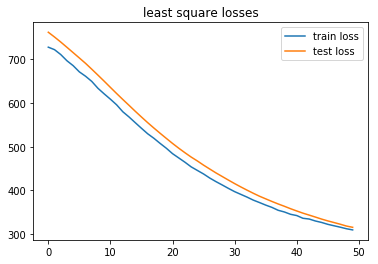

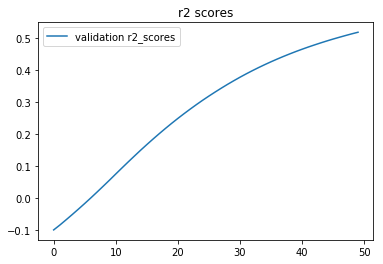

In [36]:

model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')


epoch: 0 train loss:  704.5019 val loss:  632.70013 r2_score: 0.042090231423492996
epoch: 10 train loss:  217.17519 val loss:  218.3589 r2_score: 0.6329158102919393
epoch: 20 train loss:  190.0314 val loss:  197.14091 r2_score: 0.6618685280445189
epoch: 30 train loss:  179.83557 val loss:  191.61801 r2_score: 0.6692252504204914
epoch: 40 train loss:  176.0939 val loss:  191.10977 r2_score: 0.6716716399852078
epoch: 50 train loss:  175.26915 val loss:  188.65396 r2_score: 0.6750236536046228
epoch: 60 train loss:  175.40662 val loss:  188.67119 r2_score: 0.6754960801314969
epoch: 70 train loss:  174.22356 val loss:  186.16783 r2_score: 0.6769289093510734
epoch: 80 train loss:  174.78755 val loss:  187.6458 r2_score: 0.6776642364221084
epoch: 90 train loss:  173.82378 val loss:  187.18645 r2_score: 0.6781766364865642


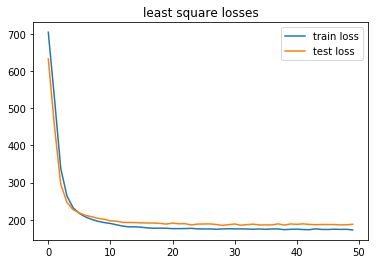

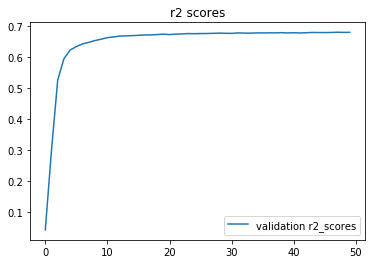

In [37]:

model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')


epoch: 0 train loss:  637.07184 val loss:  552.1337 r2_score: 0.21031676173073488
epoch: 10 train loss:  173.80762 val loss:  177.84125 r2_score: 0.7070370895788305
epoch: 20 train loss:  169.99344 val loss:  176.55385 r2_score: 0.7101322380320951
epoch: 30 train loss:  169.03102 val loss:  171.38055 r2_score: 0.7119780736687983
epoch: 40 train loss:  166.79433 val loss:  174.4607 r2_score: 0.7134870404842404
epoch: 50 train loss:  164.82597 val loss:  170.48529 r2_score: 0.7163022783374098
epoch: 60 train loss:  165.00385 val loss:  172.5608 r2_score: 0.7142296464487768
epoch: 70 train loss:  163.96602 val loss:  172.60947 r2_score: 0.7161916837769053
epoch: 80 train loss:  164.3596 val loss:  171.16661 r2_score: 0.7181915609816013
epoch: 90 train loss:  163.11627 val loss:  172.55807 r2_score: 0.7187049665190193


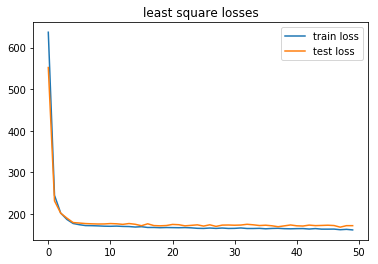

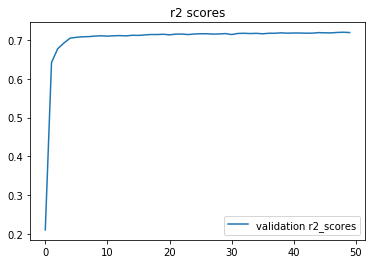

In [38]:

model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')
